In [78]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from xitorch.linalg import symeig
from scipy.linalg import eigh
from ase.io import read

In [408]:
workdir = '.'
root = f'{workdir}/examples/data/periodic/deepH_graphene/wrap'
frame = read(f'{root}/wrapped_deepH_graphene.xyz', 0)
basis = {6: [[1,0,0], [2,0,0], [2,1,-1], [2,1,0], [2,1,1]]}
nelec = {6: 6}

In [541]:
H = np.load('H_sample.npy')
S = np.load('S_sample.npy')

In [410]:
eval, C = eigh(H,S)
assert np.isclose(np.linalg.norm(H@C - S@C@np.diag(eval)), 0)
occ = [True if i <= 6*72//2 else False for i in range(72*5)]

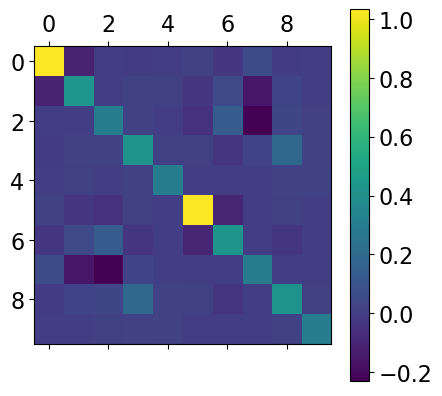

In [411]:
rho = C[:, occ]@C[:, occ].T
plt.matshow(rho[:10,:10])
plt.colorbar()

In [564]:
P = compute_lowdin(H, S, frame, basis, nelec, is_charge = False, use_overlap = False, use_H = False, return_P=True)

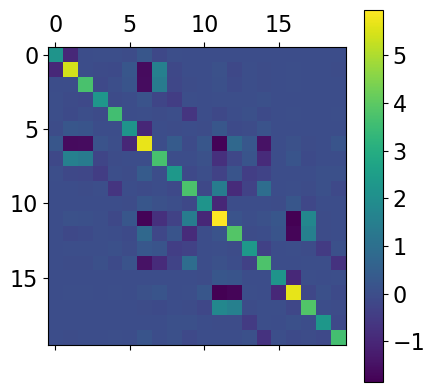

In [565]:
plt.matshow(P[:20,:20])
plt.colorbar()

In [566]:
from scipy.linalg import sqrtm

In [584]:
occ = np.ones(H.shape[0])*2 
occ = np.array([2 if i <= 72*6//2 else 0 for i in range(H.shape[0])])

eval, C = eigh(H,S)
# rho = sqrtm(S)@np.einsum('n,in,nj', occ, C, C.T.conj())@sqrtm(S)
rho = np.einsum('n,in,nj', occ, C, C.T.conj())

In [586]:
eval2, C2 = eigh(sqrtm(np.linalg.inv(S))@H@sqrtm(np.linalg.inv(S)))
rho2 = np.einsum('n,in,nj', occ, C2, C2.T.conj())

In [587]:
np.linalg.norm(rho-rho2)

9.89544370349994

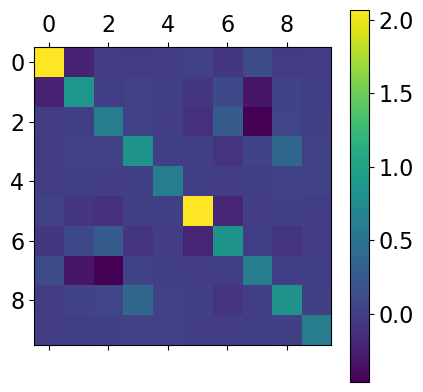

In [589]:
plt.matshow(rho[:10,:10])
plt.colorbar()

In [628]:
def compute_lowdin(H, S, frame, basis, nelec, is_charge = False, return_P = False, use_overlap = True, use_H = False):
    from scipy.linalg import sqrtm

    natm = len(frame)
    nel = sum(nelec[s] for s in frame.numbers)
    occ = np.array([2 if i <= nel//2 else 0 for i in range(H.shape[0])])

    if use_H:
        if use_overlap:
            inv_sqrtS = sqrtm(np.linalg.inv(S))
            P = inv_sqrtS@H@inv_sqrtS
        else:
            P = H
    else:
        # Solve eigenvalue problem
        eval, C = eigh(H,S)
        assert np.isclose(np.linalg.norm(H@C - S@C@np.diag(eval)), 0)
    
        # Build one-particle density matrix
        # occ = 2*np.ones_like(occ)
        rho = np.einsum('n,in,nj', occ, C, C.T.conj()) # (occ*C)[:, occ>0]@C[:, occ>0].T.conj()
        # assert np.allclose(rho, np.einsum('n,in,nj', occ, C, C.T.conj()))
    
        # Compute population matrix
        if use_overlap:
            sqrt_S = sqrtm(S)
            P = sqrt_S@rho@sqrt_S
        else:
            P = rho
    
    if return_P:
        return P

    if is_charge:
        # Compute trace of diagonal (same atom) blocks
        charges = []
        split_idx = np.cumsum([len(basis[s]) for s in frame.numbers])[:-1]
        for a, slice_ in enumerate(np.split(P, split_idx, axis = 0)):
            block = np.split(slice_, split_idx, axis = 1)[a]
            charges.append(frame.numbers[a] - np.trace(block))
        return np.array(charges)
        
    else:
        # Compute sum over atomic blocks
        charges = np.zeros((natm, natm), dtype = np.complex128)
        split_idx = np.cumsum([len(basis[s]) for s in frame.numbers])[:-1]
        for a, slice_ in enumerate(np.split(P, split_idx, axis = 0)):
            blocks = np.split(slice_, split_idx, axis = 1)
            for b, block in enumerate(blocks):
                if a == b:
                    charges[a, b] = frame.numbers[a] - np.trace(block)
                else:
                    charges[a, b] =  - np.trace(block)
        return charges

In [340]:
P = compute_lowdin(H, S, frame, basis, nelec, return_P = True, use_overlap=True)

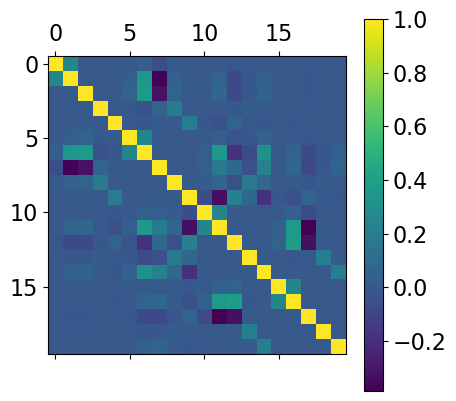

In [341]:
plt.matshow(P[:20,:20])
plt.colorbar()

In [289]:
c = compute_lowdin(H, S, frame, basis, nelec, is_charge = True)
cmat = compute_lowdin(H, S, frame, basis, nelec, is_charge = False)

In [284]:
for a in range(71):
    print(cmat[a, a+1])

-0.44778896433682897
-1.0775233873083523
-0.5406825278666294
-1.0764215067524567
-0.6438846081507064
-1.025313353837984
-0.12217977840788341
-0.9049913969527608
-0.27845977213182127
-0.7401352847984776
-0.4848893891822239
0.2182786095004831
-0.4320081921498531
-1.0649937588361766
-0.5325705480155871
-1.1209707384758494
-0.6877353222955759
-1.1919406424000498
-0.8372744382490565
-0.9296838095953909
-0.3243264577916082
-0.9805053318674761
-0.1787934680246086
0.18173540009156688
-0.3679663179101169
-1.1216250681245956
-0.2442084868411146
-1.038523121071194
-0.2656054664621857
-0.8861328097882354
-0.4660466506124961
-1.0385910930300883
-0.5632744577082961
-1.1729884756007884
-0.5725896714794956
0.1570123220503176
-0.12442436049080444
-1.0764049180903594
-0.44464293474711947
-0.8780366100600061
-0.14599708732553618
-0.7798756156786182
0.03274780299906482
-0.6763443074028338
-0.23609468157332306
-0.704437112521042
-0.3930212229970306
0.18675271775311622
-0.15745206510901982
-0.68527122216980

1.4230626678450626 -1.0775233873083523


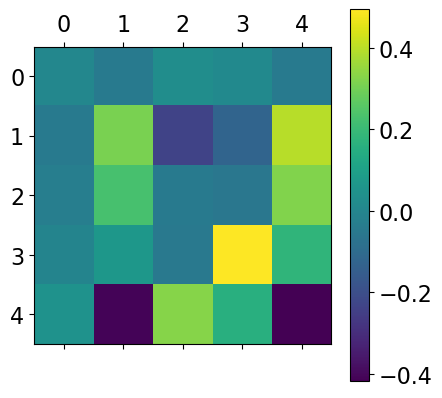

In [285]:
a = 1
b = a+1
plt.matshow(P[a*5:(a+1)*5, b*5:(b+1)*5])
plt.colorbar()
print(frame.get_distance(a,b,mic=True), cmat[a,b])

In [471]:
def rho_vs_d(frame, rho, mic = True, cutoff = np.inf):
    dist = []
    char = []
    for a in range(len(frame)):
        for b in range(len(frame)):
            d = frame.get_distance(a, b, mic = mic)#True)
            if d >= cutoff:
                continue
            cc = rho[a, b]
            dist.append(d)
            char.append(cc)
    return dist, char

In [420]:
import metatensor.torch as mts
features=mts.load("graphene_deepH")

In [445]:
from ase.visualize import view
view(frame)

<Popen: returncode: None args: ['/home/pegolo/micromamba/envs/sci/bin/python...>

In [466]:
dist_f = []
feat = []
for s, v in zip(features[0].samples, features[0].values):
    i, j = s['center'], s['neighbor']
    T = s.values[3:6]*1.0
    
    if torch.norm(T).item() > 0:
        continue
    d = frame.get_distance(i, j, mic = False) #np.linalg.norm(frame.get_distance(i, j, mic = False, vector = True) + frame.cell.array.T@T.numpy())
    print(i,j,d)
    
    f = v[0,0]
    dist_f.append(d)
    feat.append(f)

1 0 1.4430040533018569
2 0 2.4540114820581667
3 0 3.7321652764855444
4 0 4.934816524661077
5 0 6.171426064020903
6 0 7.387546364637282
7 0 6.20240991342293
8 0 4.970197762943937
9 0 3.8112279082903937
10 0 2.4816753276464434
11 0 1.4750054843522455
12 0 2.4978398115020384
13 0 1.4453276497080736
14 0 2.429461316353316
15 0 2.850822684195
16 0 4.3388379897164215
17 0 5.10539517834148
19 0 7.54309475113458
20 0 6.543043660067609
21 0 5.165280281366293
22 0 4.326959400452796
23 0 2.853246685914775
24 0 4.994541199810275
25 0 3.805840478487653
26 0 4.241753241718888
27 0 3.769301871291968
28 0 4.956011706588486
29 0 5.186598081123038
33 0 7.116680021780959
34 0 6.579099879273561
35 0 5.200110168123986
36 0 7.339092966575088
42 0 7.429837011193609
43 0 7.578143010185831
44 0 6.5694761650558515
45 0 7.136431505972651
46 0 6.487140303514916
47 0 7.460501310258609
48 0 4.886551560246901
49 0 6.145138855913586
50 0 6.470657208282602
51 0 7.885600947517513
54 0 6.5523651976797925
55 0 6.23232161

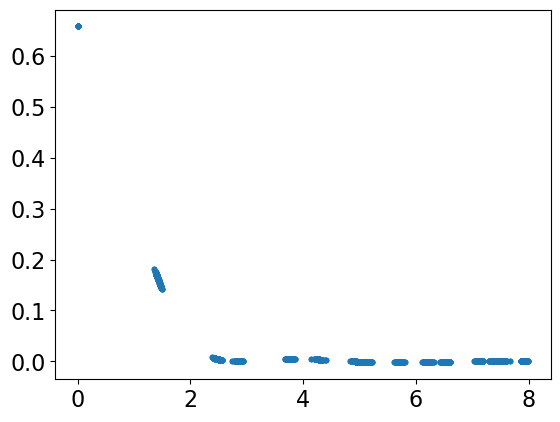

In [464]:
plt.plot(dist_f, feat, '.')

Text(0.5, 1.0, '72 C atoms in a distorted graphene supercell')

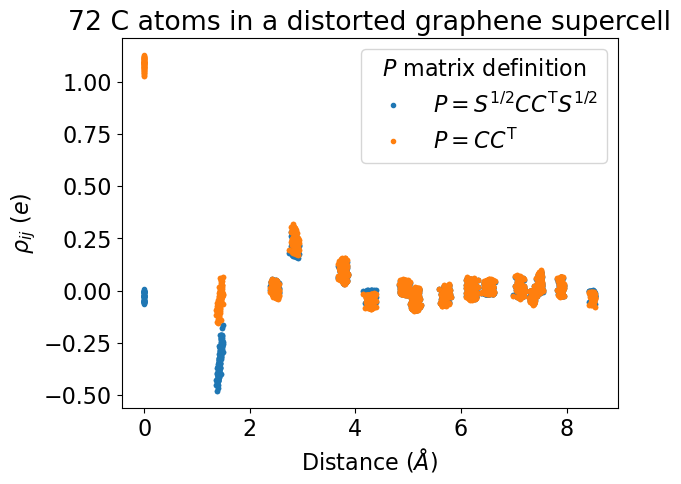

In [631]:
plt.rcParams['font.size'] = 16

rho = compute_lowdin(H, S, frame, basis, nelec, is_charge = False, use_overlap = True, use_H = False)
dist, char = rho_vs_d(frame, rho, mic = True, cutoff = 100)
plt.plot(dist, char, '.', label = '$P=S^{1/2} C C^\mathrm{T} S^{1/2}$')

rho = compute_lowdin(H, S, frame, basis, nelec, is_charge = False, use_overlap = False, use_H = False)
dist, char = rho_vs_d(frame, rho, mic = True, cutoff = 10)
plt.plot(dist, char, '.', label = '$P=C C^\mathrm{T}$')
# plt.ylim(-0.4,0.4)
plt.xlabel('Distance ($\AA$)')
plt.ylabel(r'$\rho_{ij}$ ($e$)')
plt.legend(title = '$P$ matrix definition')
plt.title('72 C atoms in a distorted graphene supercell')

In [629]:
rho = compute_lowdin(H, S, frame, basis, nelec, is_charge = False, use_overlap = True, use_H = False)
q_low = compute_lowdin(H, S, frame, basis, nelec, is_charge = True, use_overlap = True, use_H = False)

Text(0.5, 1.0, 'Graphene C$_{72}$')

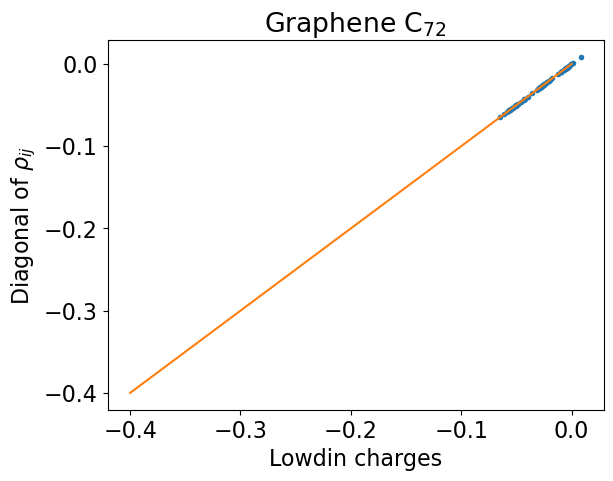

In [630]:
plt.plot(q_low, rho.diagonal().real, '.')
plt.xlabel(r'Lowdin charges')
plt.ylabel(r'Diagonal of $\rho_{ij}$')
plt.plot([-0.4, 0], [-0.4, 0])
plt.title('Graphene C$_{72}$')

In [363]:
np.trace(P@P.T)

514.4105067269709

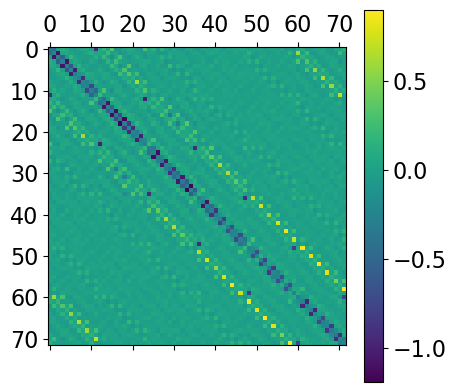

In [232]:
plt.matshow(c)
plt.colorbar()

In [154]:
split = np.cumsum([len(basis[s]) for s in frame.numbers])

In [155]:
split

array([  5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,
        70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125, 130,
       135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195,
       200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260,
       265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325,
       330, 335, 340, 345, 350, 355, 360])

In [156]:
slice_ = np.split(P, split, axis = 0)
    # print(len(np.split(slice_, split, axis = 1)))

In [157]:
slice_[-1]

array([], shape=(0, 360), dtype=float64)

In [303]:
np.random.choice(np.arange(100), 10, replace=False)

array([99, 12, 65,  2, 58, 42, 91,  6, 54, 38])

In [333]:
batch_idx = np.array([99, 12, 65,  2, 58, 42, 91,  6, 54, 38])
argsort = np.argsort(batch_idx)
inv_idx = {i: f for i, f in zip(argsort, range(len(batch_idx)))}
sorted_batch_idx = batch_idx[argsort]
recover_original = np.array([sorted_batch_idx[inv_idx[i]] for i in range(len(batch_idx))])

print(batch_idx)
print(sorted_batch_idx)
print(recover_original)

[99 12 65  2 58 42 91  6 54 38]
[ 2  6 12 38 42 54 58 65 91 99]
[99 12 65  2 58 42 91  6 54 38]


In [327]:
for i, f in enumerate(argsort):
    print(i, f)

0 3
1 7
2 1
3 9
4 5
5 8
6 4
7 2
8 6
9 0


In [312]:
print(batch_idx)
print(argsort)
print(sorted_batch_idx)

[99 12 65  2 58 42 91  6 54 38]
[3 7 1 9 5 8 4 2 6 0]
[ 2  6 12 38 42 54 58 65 91 99]


In [376]:
workdir = '.'
root = f'{workdir}/examples/data/periodic'
ORBS = 'sto-3g'
frames = read(f'{root}/c2/rotated/C2_rotated.xyz', ':')

kmesh = [15,15,1]
rfock = [np.load(f"{root}/c2/rotated/{i}/realfock_{i}.npy", allow_pickle = True).item() for i in range(len(frames))]
rover = [np.load(f"{root}/c2/rotated/{i}/realoverlap_{i}.npy", allow_pickle = True).item() for i in range(len(frames))]

rotations = np.load(f"{root}/c2/rotated/rotations.npy")

from mlelec.data.dataset import QMDataset
dataset = QMDataset(frames = frames, 
                   kmesh = kmesh, 
                   dimension = 2,
                   fock_realspace = rfock, 
                   overlap_realspace = rover, 
                   device = 'cpu', 
                   orbs = basis, 
                   orbs_name = 'sto-3g')

In [403]:
# compute_lowdin(rfock[0][0,0,0], rover[0][0,0,0])
ik = 0
for ifr in range(3):
    rho = compute_lowdin(dataset.fock_kspace[ifr][ik], dataset.overlap_kspace[ifr][ik], frames[ifr], basis, nelec, is_charge = False, use_overlap = True)               
    print(rho)
    print()

[[-1.0000145 +0.j -0.98990556-0.j]
 [-0.98990556-0.j -0.9999855 +0.j]]

[[-1.0000145 +0.j -0.98990556-0.j]
 [-0.98990556-0.j -0.9999855 +0.j]]

[[-1.0000145 +0.j -0.98990556-0.j]
 [-0.98990556-0.j -0.9999855 +0.j]]



In [404]:
rho = np.mean([compute_lowdin(dataset.fock_kspace[0][ik], dataset.overlap_kspace[0][ik], frames[0], basis, nelec, is_charge = False, use_overlap = True) for ik in range(15*15)], axis = 0)

In [405]:
rho

array([[-1.00001717-1.86316717e-17j,  0.01813456-5.75465601e-16j],
       [ 0.01813456+5.40925329e-16j, -0.99998283+2.03612315e-18j]])

In [535]:
ik = 0
H = dataset.fock_kspace[0][ik]
S = dataset.overlap_kspace[0][ik]
# Solve eigenvalue problem
eval, C = eigh(H,S)
assert np.isclose(np.linalg.norm(H@C - S@C@np.diag(eval)), 0)

# Build one-particle density matrix
natm = len(frame)
# nel = sum(nelec[s] for s in frame.numbers)
nel = 12
occ = np.array([2 if i <= nel//2 else 0 for i in range(H.shape[0])])
# occ = 2*np.ones(H.shape[0])
rho = np.einsum('n,in,nj', occ, C, C.T.conj()) # (occ*C)[:, occ>0]@C[:, occ>0].T.conj()

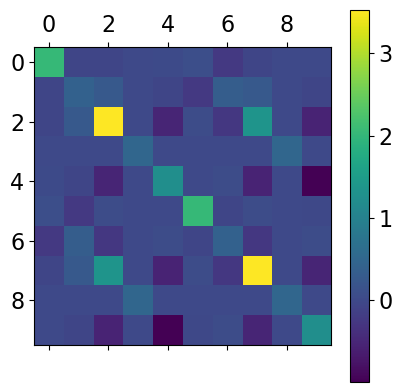

In [537]:
plt.matshow(rho.real)
plt.colorbar()

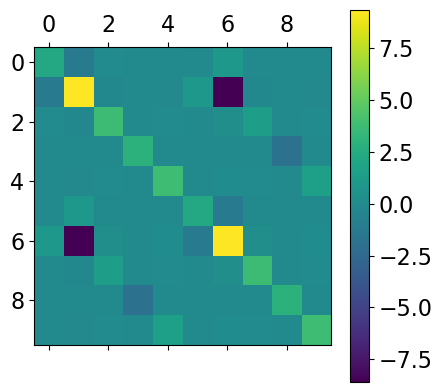

In [529]:
plt.matshow(rho.real)
plt.colorbar()